In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import IPython.display as ipd
import librosa
import librosa.display
import h5py

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.metrics import label_ranking_average_precision_score as lrap

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, MaxPool2D, Conv2D, AvgPool2D, ReLU, GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Data extraction

In [2]:
def load_train_data_df(mode='curated'):
    # Load training data filenames and labels (raw -> multilabels are represented as a string with comma separated values)
    data_folder = '/kaggle/input/freesound-audio-tagging-2019' 
    csv_path = f'{data_folder}/train_{mode}.csv'
    raw_df = pd.read_csv(csv_path, index_col='fname')
        
    # Extract list of expected labels
    sub = pd.read_csv('/kaggle/input/freesound-audio-tagging-2019/sample_submission.csv', index_col='fname')
    labels_list = sub.columns.values 

    # Encode multi-labels in a binary vector
    splitted_labels = [ labels.split(',') for labels in raw_df['labels'].values ]
    encoder = MultiLabelBinarizer()
    encoded_labels = encoder.fit_transform(splitted_labels)

    # Create a new pandas Dataframe to represent training labels as binary vectors
    labels_df = pd.DataFrame(data=encoded_labels, index=list(raw_df.index), columns=labels_list)
    
    return labels_df

In [3]:
# Load data filenames and labels
train_curated_labels = load_train_data_df(mode='curated')
train_noisy_labels = load_train_data_df(mode='noisy')
test_labels = pd.read_csv('/kaggle/input/freesound-audio-tagging-2019/sample_submission.csv', index_col='fname')

# Main info about the training/testing sets
print(f'{train_curated_labels.shape[1]} possible classes.')
print(f'{train_curated_labels.shape[0]} curated training samples.')
print(f'{train_noisy_labels.shape[0]} noisy training samples.')
print(f'{test_labels.shape[0]} test samples.')

train_curated_labels.sample(5)

80 possible classes.
4970 curated training samples.
19815 noisy training samples.
3361 test samples.


,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
d368834c.wav,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60b984e4.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eddce22d.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6abd24fe.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dcc12be7.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# OPTIONAL - Reduced train dataset (10 random classes ~750 curated samples and ~3000 noisy labels)
use_reduced_data = True
n_classes = 80

if use_reduced_data:
    n_classes = 10
    labels_list = np.random.choice(train_curated_labels.columns, 10, replace=False)
    samples_to_keep = train_curated_labels.loc[:, labels_list].sum(axis=1) > 0
    train_curated_labels = train_curated_labels.loc[samples_to_keep, labels_list]
    print(f'Using reduced curated dataset {train_curated_labels.shape}.')
    print(train_curated_labels.sum())
    
    samples_to_keep = train_noisy_labels.loc[:, labels_list].sum(axis=1) > 0
    train_noisy_labels = train_noisy_labels.loc[samples_to_keep, labels_list]
    print(f'Using reduced noisy dataset {train_noisy_labels.shape}.')
    print(train_noisy_labels.sum())
    
train_curated_h5 = '/kaggle/input/fat2019wav/train_curated_wav.h5'
train_curated_ids = np.array([ 't' + file.split('.')[0] for file in train_curated_labels.index.values ])

Using reduced curated dataset (705, 10).
Microwave_oven                        75
Church_bell                           75
Drawer_open_or_close                  75
Chewing_and_mastication               75
Accelerating_and_revving_and_vroom    75
Dishes_and_pots_and_pans              75
Sneeze                                63
Harmonica                             75
Chink_and_clink                       75
Finger_snapping                       75
dtype: int64
Using reduced noisy dataset (2942, 10).
Microwave_oven                        300
Church_bell                           300
Drawer_open_or_close                  300
Chewing_and_mastication               300
Accelerating_and_revving_and_vroom    300
Dishes_and_pots_and_pans              300
Sneeze                                300
Harmonica                             300
Chink_and_clink                       300
Finger_snapping                       300
dtype: int64


# 2. Data exploration (fat2019wav dataset)

In [32]:
def load_h5(sample_ids, h5_filename):
    if not isinstance(sample_ids, np.ndarray):
        sample_ids = np.array([sample_ids])
    with h5py.File(h5_filename, mode='r') as dataset:
        samples = [ convert_to_float(dataset[f][()]) for f in sample_ids ]
    return samples

def load_random_wav(sample_ids, h5_filename):
    random_id = np.random.choice(train_curated_ids, 1)[0]
    sample = load_h5(random_id, h5_filename)[0]
    return random_id, sample

def get_label(sample_id, labels_df, decode_label=False):
    label = labels_df.loc[sample_id[1:] + '.wav']
    if decode_label:
        label = list(label[label>0].index)
    return label 

def listen_sample(sample, sr=44100):
    return IPython.display.display(ipd.Audio(data=sample, rate=sr))

def convert_to_float(sample):
    return np.array(sample) / 255.

def show_signal(sample, mode='temporal', ax=None, sr=44100):
    if ax is None:
        fig, ax = plt.subplots()
        
    if mode == 'temporal':
        librosa.display.waveplot(sample, sr=sr, ax=ax)
        ax.set_title('Temporal')
        print(f'Temporal: {sample.shape}')
    elif mode == 'stft':
        stft = librosa.stft(sample)
        stft = librosa.amplitude_to_db(abs(stft), ref=np.max)
        librosa.display.specshow(stft, x_axis='time', y_axis='log', sr=sr, ax=ax)
        ax.set_title('STFT')
        print(f'STFT: {stft.shape}')
    elif mode == 'mfcc':
        mfccs = librosa.feature.mfcc(sample, sr=sr, n_mfcc=20)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax)
        ax.set_title('MFCC')
        print(f'MFCC: {mfccs.shape}')
    elif mode == 'logmel':
        mel = librosa.feature.melspectrogram(y=sample, sr=sr, n_fft=1024, hop_length=512, n_mels=128, fmin=20, fmax=sr//2)
        mel = librosa.core.power_to_db(mel, ref=np.max)
        librosa.display.specshow(mel, sr=sr, x_axis='time', y_axis='mel', hop_length=512, fmin=20, fmax=sr//2, ax=ax)
        ax.set_title('Log-Mel')
        print(f'Log-Mel: {mel.shape}')

Length: 1.14s
Labels: ['Chewing_and_mastication']
Temporal: (50176,)
STFT: (1025, 99)
MFCC: (20, 99)
Log-Mel: (128, 99)


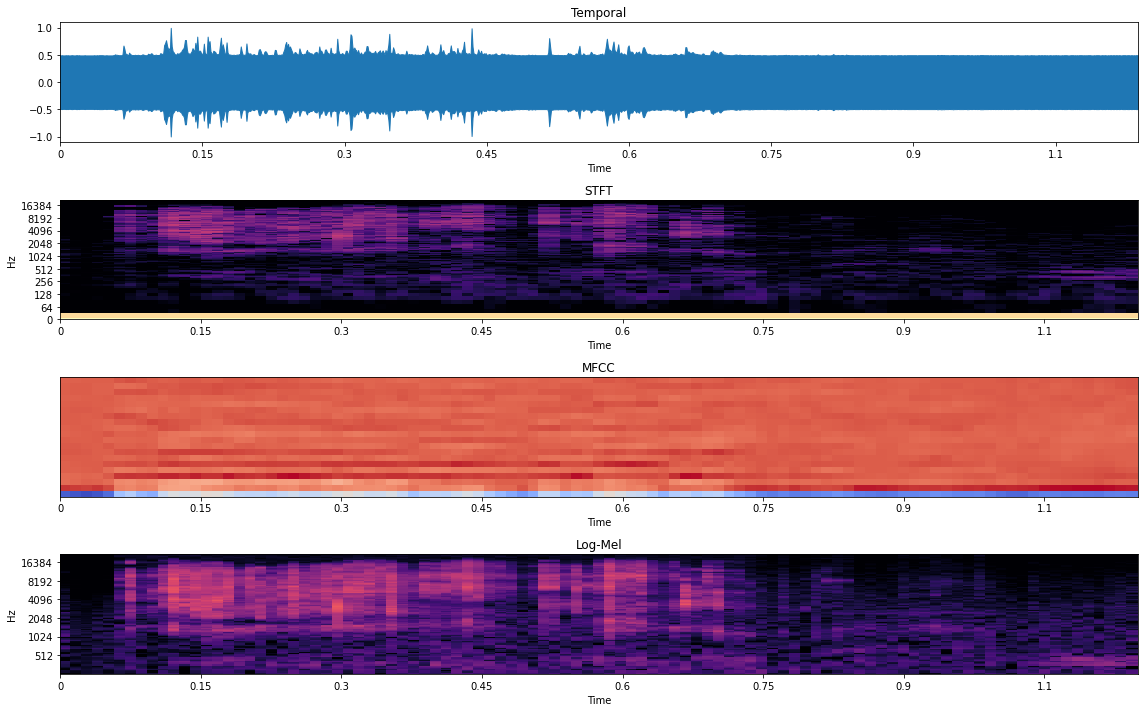

In [33]:
# Load random .wav sample
sr = 44100
random_id, sample = load_random_wav(train_curated_ids, train_curated_h5)
labels = get_label(random_id, train_curated_labels, decode_label=True)
listen_sample(sample)

print(f'Length: {len(sample)/sr:.2f}s')
print(f'Labels: {labels}')

fig, ax = plt.subplots(4, 1, figsize=(16,10))
show_signal(sample, mode='temporal', ax=ax[0])
show_signal(sample, mode='stft', ax=ax[1])
show_signal(sample, mode='mfcc', ax=ax[2])
show_signal(sample, mode='logmel', ax=ax[3])

plt.tight_layout()

**STFT (Short Term Fourier Transform):** Computes the amplitude of the frequencies for different bands  over time. <br>
**MFCC (Mel Frequency Cepstral Coefficients):** Describe the instantaneous spectral envelope shape of the speech signal. [[source](https://wiki.aalto.fi/display/ITSP/Deltas+and+Delta-deltas)] <br>
**Mel spectrogram:** Similar to STFT but represented in the Mel scale (non-linear transformation of the frequency scale), that is closer to how humans perceive sounds.

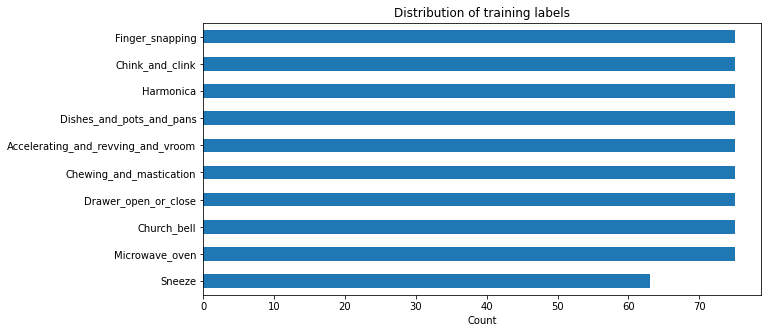

In [7]:
# Histogram of labels distribution
fig, ax = plt.subplots(figsize=(10,5))
train_curated_labels.sum(axis=0).sort_values(ascending=True).plot(kind='barh', x='Count', y=train_curated_labels.columns, ax=ax)
ax.set_xlabel('Count')
ax.set_title('Distribution of training labels');

**Remark:** Most labels are fairly equally distributed, but we might want to oversample the last 14 labels in order to have equally represented labels.

In [8]:
# Extract duration of each sample in the curated training set
curated_len_df = pd.DataFrame(columns=['fname', 'length'])
curated_len_df.set_index(['fname'], inplace=True)

for file in train_curated_ids:
    sample = load_h5(file, train_curated_h5)[0]
    
    fname = file.split('/')[-1]
    curated_len_df.loc[fname] = len(sample) / sr

curated_len_df.sample(5)

,length
fname,
tec61b025,2.031746
t29f37eca,0.462041
t02c86123,6.339660
te339765a,0.162540
t64dbaa9c,2.290839


Smallest duration: 0.15s
Largest duration: 29.73s
Mean duration: 7.31s
Median duration: 4.01s


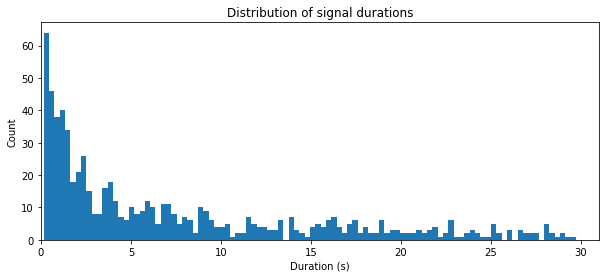

In [9]:
# Histogram of signal length distribution
fig, ax = plt.subplots(figsize=(10,4))
curated_len_df['length'].sort_values(ascending=False).plot(kind='hist', bins=100, ax=ax)
ax.set_xlim([0,31])
ax.set_ylabel('Count')
ax.set_xlabel('Duration (s)')
ax.set_title('Distribution of signal durations');

print(f'Smallest duration: {curated_len_df["length"].min():.2f}s')
print(f'Largest duration: {curated_len_df["length"].max():.2f}s')
print(f'Mean duration: {curated_len_df["length"].mean():.2f}s')
print(f'Median duration: {curated_len_df["length"].median():.2f}s')

**Remark:** >50% of all samples are less than 5s long. We should think about a cropping strategy in order to have fixed-length samples.

# 3. Feature extraction

We can extract log melspectrogram features (n_mels=128) using Librosa and the following parameters:
- sr = 44100
- nmels = 128 
- nfft = 1024
- hop_length = 512
- fmin = 20
- fmax = sr//2

See [Kaggle notebook](https://www.kaggle.com/obione26/freesound-audio-tagging-feature-extraction) ([Colab version](https://colab.research.google.com/drive/1uTEdXfazhonVHxP4vmuYAgG2BexzHfcu?usp=sharing))


# 4. Data modeling


Model architecture inspired from [this notebook](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data) and this [github](https://github.com/sainathadapa/kaggle-freesound-audio-tagging/blob/master/approaches_all.md). <br>
Augmentation methods inspired from [this notebook](https://www.kaggle.com/osciiart/resnet34-multi1024).

**Metrics:**
- **LWLRAP (Label-Weighted Label-Ranking Average Precision):** Evaluates the ability of a model (given the predicted ranked list of labels probabilities) to give higher probabilities to the relevant labels.

In [47]:
# Helper functions of this section
def extract_mel(sample, n_mels=128, sr=44100, hop=512, log=False):
    """ Return melspectrogram of shape (n_mels, len(sample)/hop + 1). """
    mel = librosa.feature.melspectrogram(sample, sr=sr, n_fft=1024, hop_length=hop, n_mels=n_mels, fmin=20, fmax=sr//2)
    if log:
        mel = librosa.core.power_to_db(mel, ref=1.0, amin=1e-10, top_db=None)
    return mel.astype(np.float32)

def random_chunk(x, chunk_size=44100, hop_len=512):
    """ Extract fixed-size chunk from signal. If signal shorter than chunk size -> repeat pattern. Else -> random cropping.
    Parameters:
    - chunk_size (int, >0): Number of frames in a chunk (corresponds to chunk_size*hop_len/sr seconds).
    - hop_len (int, >0): Number of temporal frames represented in one mel frame.
    """
    n_frames = x.shape[-1]
    
    if n_frames <= chunk_size:
        x = np.tile(x, chunk_size//n_frames + 1)
        x = x[..., :chunk_size]
    else:
        roi_start = np.random.randint(0, n_frames - chunk_size)
        x = x[..., roi_start:roi_start + chunk_size]
    return x

def random_ampli(x, min_gain=0.5, max_gain=2):
    rate = (max_gain - min_gain) * np.random.random() + min_gain
    return rate * x

def mixup(x, label, source_ids, source_h5, source_labels, chunk_size, hop_len, alpha=1.):
    """ Return a weighted combination of audio samples and labels. """
    if x.shape[-1] != chunk_size:
        x = random_chunk(x, chunk_size, hop_len)
    
    # Load second signal and associated label
    random_id2, sample2 = load_random_wav(source_ids, source_h5)
    sample2 = random_chunk(sample2, chunk_size, hop_len)
    label2 = get_label(random_id2, source_labels)
    
    # Combine input signals and labels
#     rate = np.random.beta(alpha, alpha)
    rate = np.random.random()
    x = rate * x + (1-rate) * sample2
    label = rate * label + (1-rate) * label2
    
    return x, label

def normalize(X):
    mean = X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, keepdims=True)
    X = (X - mean) / (std + 1e-7)
    return X

class DataLoader(Sequence):
    def __init__(self, h5_file, sample_ids, labels_df, batch_size, chunk_size=44100, n_mels=128, hop=512, sr=44100, compute_deltas=False, shuffle=True):
        self.h5_file = h5_file
        self.sample_ids = np.array(sample_ids)
        self.labels_df = labels_df
        self.batch_size = batch_size
        self.chunk_size = chunk_size
        self.n_mels = n_mels
        self.hop = hop
        self.sr = sr
        self.compute_deltas = compute_deltas
        self.shuffle = shuffle
        self.on_epoch_end()
        
        # FIXME: Create mel dataset
        self.X = load_h5(self.sample_ids, self.h5_file)
        self.X = [ extract_mel(x, n_mels, sr, hop, log=True) for x in self.X]
        self.y = np.array([ get_label(id, self.labels_df) for id in self.sample_ids ])

    def __len__(self):
        """ Corresponds to the number of steps in one epoch. """
        return int(np.ceil(len(self.sample_ids) / float(self.batch_size)))

    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size: (idx+1)*self.batch_size]
        batch_X, batch_y = self.generate_Xy(indexes)
        
        if self.compute_deltas:
            pass
                    
        batch_X = normalize(batch_X)
        batch_X = np.expand_dims(batch_X, axis=-1)
        
        return batch_X, batch_y

    def generate_Xy(self, indexes):
        # Fixed-length size 
        X = [ random_chunk(self.X[i], self.chunk_size, self.hop) for i in indexes ]
        y = self.y[indexes]
#             x = random_ampli(x)
#             x, label = mixup(x, label, self.mel_paths, self.labels_df, self.chunk_size, self.hop, alpha=1.)
        return np.array(X).astype(np.float32), np.array(y).astype(np.float32)
    
    def on_epoch_end(self):
        """ Shuffle the data after each epoch to avoid oscillation patterns in the loss. """
        self.indexes = np.arange(0, len(self.sample_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
class CNN9:
    def __init__(self, n_feats=128, chunk_size=44100, hop=512, n_classes=80):
        self.n_feats = n_feats
        self.n_frames = int(chunk_size / hop + 1)
        self.n_classes = n_classes
        
    def add_conv_block(self, n_filts, k_size):
        self.model.add(Conv2D(n_filts, k_size, padding='same'))
        self.model.add(LeakyReLU(alpha=0.01))
        self.model.add(BatchNormalization(momentum=0.1))
        self.model.add(ReLU())
        
        self.model.add(Conv2D(n_filts, k_size, padding='same'))
        self.model.add(LeakyReLU(alpha=0.01))
        self.model.add(BatchNormalization(momentum=0.1))
        self.model.add(ReLU())
        
    def create_model(self):
        self.model = Sequential()
        self.model.add(Input(shape=(self.n_feats, self.n_frames, 1)))

        self.add_conv_block(n_filts=64, k_size=(3,3))
        self.model.add(AvgPool2D(pool_size=(2,2)))

        self.add_conv_block(n_filts=128, k_size=(3,3))
        self.model.add(AvgPool2D(pool_size=(2,2)))

        self.add_conv_block(n_filts=256, k_size=(3,3))
        self.model.add(AvgPool2D(pool_size=(2,2)))

        self.add_conv_block(n_filts=512, k_size=(3,3))
        self.model.add(AvgPool2D(pool_size=(1,1)))

        self.model.add(Lambda(lambda x: K.max(K.mean(x, axis=3), axis=2)))
        self.model.add(Dense(512, activation='relu'))
        self.model.add(Dense(self.n_classes, activation='softmax'))

        return self.model

def create_shallow_cnn(n_feats=128, chunk_size=512, n_classes=80):
    model = Sequential()
    model.add(Input(shape=(n_feats, chunk_size, 1)))

    model.add(Conv2D(48, 11, strides=(2,3),kernel_initializer='he_uniform', activation='relu', padding='same'))
    model.add(MaxPooling2D(3, strides=(1,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, 5, strides=(2,3), kernel_initializer='he_uniform', activation='relu', padding='same'))
    model.add(MaxPooling2D(3, strides=2))
    model.add(BatchNormalization())

    model.add(Conv2D(192, 3, strides=1,kernel_initializer='he_uniform', activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(192, 3, strides=1,kernel_initializer='he_uniform', activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, strides=1,kernel_initializer='he_uniform', activation='relu', padding='same'))
    model.add(MaxPooling2D(3, strides=(1,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='linear'))
    return model    
    
def create_mobile_cnn(n_feats=128, chunk_size=512, n_classes=80):
    model = Sequential()
    model.add(Input(shape=(n_feats, chunk_size, 1)))
              
    model.add(BatchNormalization())
    model.add(Conv2D(10, kernel_size=(1,1), padding='same', activation='relu'))
    model.add(Conv2D(3, kernel_size=(1,1), padding='same', activation='relu'))
    
    mobilenet = MobileNetV2(include_top=False)
    mobilenet.layers.pop(0)
    model.add(mobilenet)
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(n_classes, activation='softmax'))
    return model
              
def plot_metric(hist, metric='loss', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.plot(hist.history[metric])
    ax.plot(hist.history[f'val_{metric}'])
    ax.set_title(f'{metric.upper()} vs Epoch')
    ax.set_ylabel(metric.upper())
    ax.set_xlabel('Epochs')
    ax.legend(['train', 'validation'], loc='upper right')
#     plt.show()
    
def lw_lrap(y_true, y_pred):
    """ Compute label-weighted label-ranking average precision. 
    Source: https://github.com/qiuqiangkong/dcase2019_task2/blob/master/utils/lwlrap.py"""
    
    weights = K.sum(y_true, axis=1)
    score = tf.py_function(lrap, [y_true, 
                                  y_pred, 
                                  weights],
                           tf.float32)                               
    return score

In [2]:
def create_mobile_cnn(n_feats=128, chunk_size=512, n_classes=80):
    model = Sequential()
    model.add(Input(shape=(n_feats, chunk_size, 1)))
              
    model.add(BatchNormalization())
    model.add(Conv2D(10, kernel_size=(1,1), padding='same', activation='relu'))
    model.add(Conv2D(3, kernel_size=(1,1), padding='same', activation='relu'))
    
    mobilenet = MobileNetV2(include_top=False)
    mobilenet.layers.pop(0)
    model.add(mobilenet)
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [3]:
model=create_mobile_cnn()

9412608/9406464 [==============================] - 1s 0us/step


In [8]:
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 512, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 512, 10)      20        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 512, 3)       33        
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4

In [11]:
# Try out mixup
hop_len = 512
chunk_len = 4
chunk_size = sr * chunk_len

id1, sample1 = load_random_wav(train_curated_ids, train_curated_h5)
label1 = get_label(id1, train_curated_labels)
print(f'Initial label: {label1[label1>0]}')
sample1 = random_chunk(sample1, chunk_size, hop_len)

mixup_sample, mixup_label = mixup(sample1, label1, train_curated_ids, train_curated_h5, train_curated_labels, chunk_size, hop_len, alpha=1)
print(f'Mixup label: {mixup_label[mixup_label>0]}')

listen_sample(sample1)
listen_sample(mixup_sample)

Initial label: Church_bell    1
Sneeze         1
Name: e6f82a4a.wav, dtype: int64
Mixup label: Church_bell                 0.798846
Dishes_and_pots_and_pans    0.201154
Sneeze                      0.798846
Chink_and_clink             0.201154
dtype: float64


In [ ]:
# Try out random gain
id1, sample1 = load_random_wav(train_curated_ids, train_curated_h5)
listen_sample(sample1)

ampli_sample = random_ampli(sample1)
listen_sample(ampli_sample)

In [48]:
# Feature extraction hyperparameters
sr = 44100
chunk_size = sr
n_feats = 128
hop = 512

# Training hyperparameters
batch_size = 32

# Training/validation splits
SEED = 42
kf = list(ShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED).split(np.arange(len(train_curated_ids))))
# kf = list(KFold(n_splits=5, shuffle=True, random_state=SEED).split(np.arange(len(train_mix_mel_paths))))

models = {}
hists = {}
for fold_idx, (train_ids, valid_ids) in enumerate(kf):
    print(f'Fold {fold_idx + 1} - {len(train_ids)} train ids / {len(valid_ids)} valid ids')
    
    # Define data loader
    train_loader = DataLoader(train_curated_h5, train_curated_ids[train_ids], train_curated_labels.iloc[train_ids], batch_size, chunk_size, n_feats, hop, sr)
    valid_loader = DataLoader(train_curated_h5, train_curated_ids[valid_ids], train_curated_labels.iloc[valid_ids], batch_size, chunk_size, n_feats, hop, sr)

    # Define architecture
    model = CNN9(n_feats, chunk_size, hop_len, n_classes).create_model()

    # Train model
    es = EarlyStopping(monitor='val_acc', mode='max', patience=5)
    mc = ModelCheckpoint(f'best_model_{fold_idx}.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) # lw_lrap

    hist = model.fit(train_loader, steps_per_epoch=len(train_loader),
                     validation_data=valid_loader,
                     validation_steps=len(valid_loader),
                     epochs=50, verbose=1, callbacks=[es, mc])
    
    # Save history and trained model
    models[f'fold_{fold_idx}'] = model
    hists[f'fold_{fold_idx}'] = hist

Fold 1 - 564 train ids / 141 valid ids
Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,128,44100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_12/conv2d_68/Conv2D (defined at <ipython-input-48-7df28e10f8e0>:36) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_14284]

Function call stack:
train_function


In [ ]:
fig, ax = plt.subplots(len(kf) +1 , 2, figsize=(15 ,3*len(kf)))

for fold_idx in range(len(kf)):
    plot_metric(hists[f'fold_{fold_idx}'], 'loss', ax=ax[fold_idx, 0])
    plot_metric(hists[f'fold_{fold_idx}'], 'acc', ax=ax[fold_idx, 1])
    fig.tight_layout()

# Submission

In [ ]:
def load_random_test(paths_list):
    path = np.random.choice(paths_list, 1)[0]
    mel = np.load(path)
    return mel

def prepare_mel(mel, chunk_size=256, sr=44100):
    n_mels, n_frames = mel.shape
    
    if n_frames <= chunk_size:
        x = np.tile(mel, chunk_size//n_frames + 1)
        x = x[np.newaxis, :, :chunk_size]
    else:
        n_crops = n_frames // chunk_size + 1
        x = np.pad(mel, ([0,0], [0, n_crops * chunk_size - n_frames]))
        x = np.split(x, n_crops, axis=-1)
        x = np.array(x)
        
    features = normalize(x)
    features = np.expand_dims(features, axis=-1)
    
    return features

def show_pred(models, mel, labels_list, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,4))
    
    if not isinstance(models, list):
        models = [models]
    
    mel = prepare_mel(mel)
    pred = average_models_pred(models, mel)
    
    top5_idx = np.argsort(pred)[::-1][:5]
    top_labels = labels_list[top5_idx]
    top_preds = pred[top5_idx]
    
    ax.bar(top_labels, top_preds)
    
def average_models_pred(models, mel):
    preds = [ np.mean(m.predict(mel), axis=0) for m in models ]
    return np.mean(preds, axis=0)
    
def create_submission(models, save_name='model_preds'):
    submission_df = pd.read_csv('/kaggle/input/freesound-audio-tagging-2019/sample_submission.csv', index_col='fname')
    test_mel_paths = glob.glob('/kaggle/input/logmel128/test_logmel/*.npy')
    
    for path in test_mel_paths:
        mel = np.load(path)
        mel = prepare_sample(mel)
        pred = average_models_pred(models, mel)        
        submission_df.loc[path.split('/')[-1]] = pred
    
    submission_df.to_csv(f'{save_name}.csv',index = False)
    print(f'Successfully created {save_name}.csv !')
    
    return submission_df

In [ ]:
mel_test = load_random_test(test_mel_paths)

fig, ax = plt.subplots(figsize=(15, 3))

trained_models = list(models.values())
# trained_models = [ m.load_weights(f'best_model_{i}.h5') for i,m in enumerate(trained_models) ]

show_pred(trained_models, mel_test, train_curated_labels.columns, ax=ax)    
fig.tight_layout()

In [ ]:
audio = convert_spectra2sound(mel_test)
listen_sample(audio)

In [ ]:
sub = create_submission(model1)

# TODO

**Debugging:**
- [x] Try out on a reduced dataset (~10 labels) -> add a flag to load reduced dataset.

**Preprocessing:**
- [ ] Trim silences
- [ ] Augmentation pipeline (random shift, pitch, noise, ...) [Mixup paper](https://arxiv.org/pdf/1710.09412.pdf)
- [x] Improving feature extraction (import as separate dataset)
- [ ] Write signal transformers (wrap padding, centering, trimming)

**Modelling:**
- [ ] Reproduce baseline [github](https://github.com/qiuqiangkong/dcase2019_task2)
- [ ] Implement approach from [this paper](http://dcase.community/documents/challenge2019/technical_reports/DCASE2019_Akiyama_94_t2.pdf).
- [ ] Take a look at [this notebook](https://www.kaggle.com/romul0212/freesound-predict-dataset) and associated [github](https://github.com/lRomul/argus-freesound)
- [ ] Try out the approach described in [this paper](https://arxiv.org/pdf/1904.03476.pdf).
- [ ] Explore ensemble learning strategy [from this paper](https://arxiv.org/pdf/1810.12832.pdf) and associated [github](https://github.com/Cocoxili/DCASE2018Task2/).